# Test GEModelTools - HANK

This notebook shows how to **solve a simple Heterogenous Agent New Keynessian (HANK) model** using the `GEModelTools` package.

**The steps of the sequence-space solution method are:**

1. Find the stationary equilibrium (steady state for aggregates and distribution).
2. Compute Jacobians of the household block and the full model (to unknowns and shocks)
3. Find the non-linear transition path or the linearized impulse responses to a given shock path.
4. Simulate the linearized model with aggregate risk

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from HANKModel import HANKModelClass

# Setup

In [2]:
model = HANKModelClass(name='baseline')

# Step 1: Steady state

In [6]:
model.find_ss(do_print=True)

steady state found in 5.7 secs
 beta   =   0.9872
 varphi =   0.7855

Discrepancy in B =  -0.00000000
Discrepancy in C =   0.00000000
Discrepancy in N =  -0.00000000


In [7]:
par = model.par
ss = model.ss
path = model.path
sim = model.sim

## Policy functions

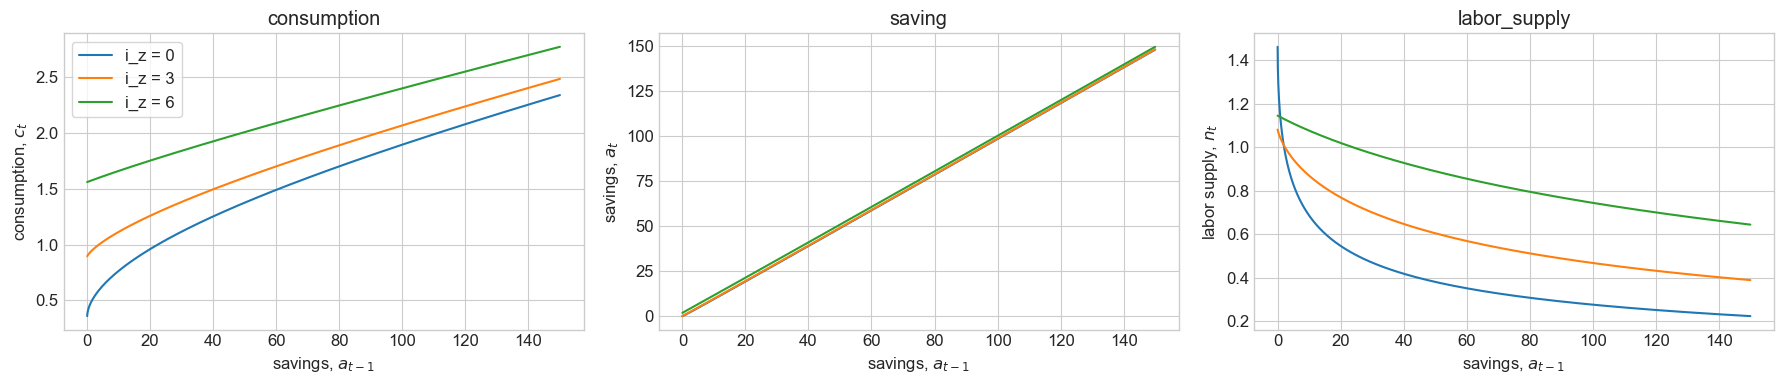

In [13]:
fig = plt.figure(figsize=(18,4),dpi=100)
a_max = 500

# a. consumption
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,1)
ax.set_title(f'consumption')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.c[0,i_z,I],label=f'i_z = {i_z}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')

# b. saving
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,2)
ax.set_title(f'saving')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.a[0,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('savings, $a_{t}$')

# c. labor supply
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,3)
ax.set_title(f'labor_supply')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.ell[0,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('labor supply, $n_{t}$')

fig.tight_layout()

## Simulation

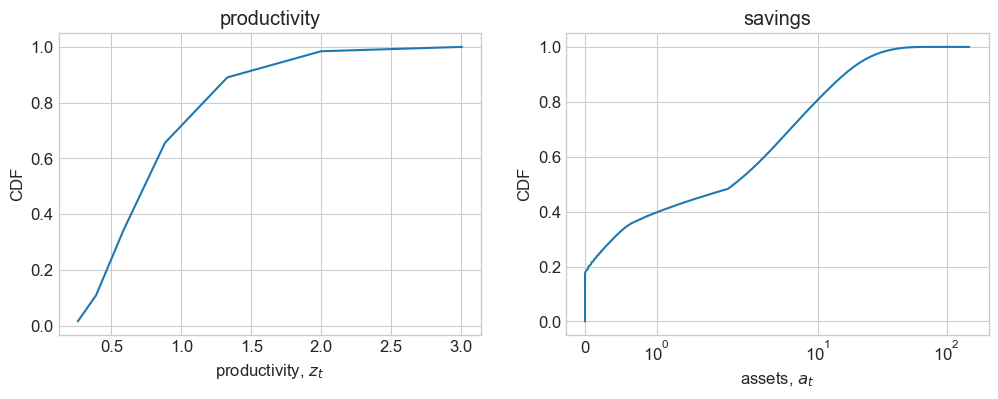

In [14]:
fig = plt.figure(figsize=(12,4),dpi=100)

# a. income
ax = fig.add_subplot(1,2,1)
ax.set_title('productivity')

y = np.cumsum(np.sum(ss.D[0],axis=1))
ax.plot(par.z_grid,y/y[-1])

ax.set_xlabel('productivity, $z_{t}$')
ax.set_ylabel('CDF')

# b. assets
ax = fig.add_subplot(1,2,2)
ax.set_title('savings')
y = np.insert(np.cumsum(np.sum(ss.D[0],axis=0)),0,0.0)
ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),y/y[-1])
        
ax.set_xlabel('assets, $a_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')


# Step 2: Compute Jacobians (incl. tests)

**Household transition path:**

note: inputs = steady state value -> expected: constant value (straigt line)

household problem solved along transition path in 0.5 secs
household problem simulated along transition in 1.6 secs



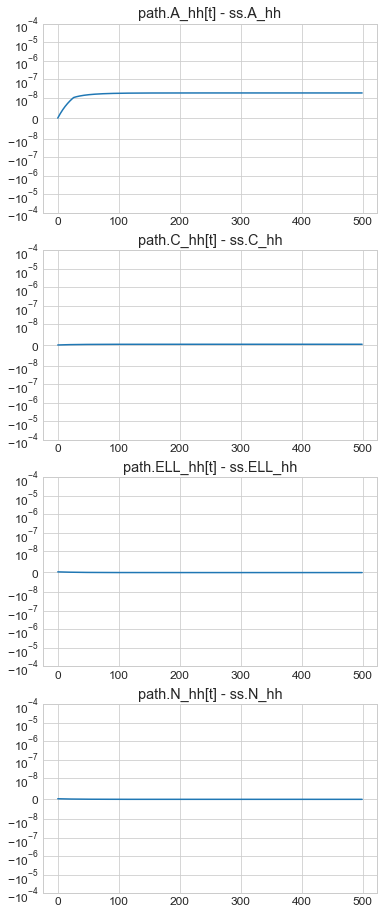

In [15]:
model.test_hh_path()

**Full transition path:**

In [16]:
model.test_path()

note: inputs = steady state value -> expected: no difference to steady state and zero errors

difference to value at steady state:
A              : t0 =  0.0e+00, max abs.  0.0e+00
B              : t0 =  0.0e+00, max abs.  0.0e+00
C              : t0 =  0.0e+00, max abs.  0.0e+00
d              : t0 =  0.0e+00, max abs.  0.0e+00
G              : t0 =  0.0e+00, max abs.  0.0e+00
i              : t0 =  0.0e+00, max abs.  0.0e+00
N              : t0 =  0.0e+00, max abs.  0.0e+00
pi             : t0 =  0.0e+00, max abs.  0.0e+00
adjcost        : t0 =  0.0e+00, max abs.  0.0e+00
r              : t0 =  0.0e+00, max abs.  0.0e+00
istar          : t0 =  0.0e+00, max abs.  0.0e+00
tau            : t0 =  0.0e+00, max abs.  0.0e+00
w              : t0 =  0.0e+00, max abs.  0.0e+00
Y              : t0 =  0.0e+00, max abs.  0.0e+00
Z              : t0 =  0.0e+00, max abs.  0.0e+00
A_hh           : t0 =  1.3e-12, max abs.  1.8e-08
C_hh           : t0 = -6.7e-13, max abs.  3.4e-10
ELL_hh         : t0

note: differences should only be due to numerical errors

direct method:
finding Jacobian wrt. ghost          : 50 100 150 [computed in 0.8 secs]
finding Jacobian wrt. d              : 50 100 150 [computed in 0.8 secs]
finding Jacobian wrt. r              : 50 100 150 [computed in 0.8 secs]
finding Jacobian wrt. tau            : 50 100 150 [computed in 0.8 secs]
finding Jacobian wrt. w              : 50 100 150 [computed in 0.8 secs]
household Jacobian computed in 4.1 secs

fake news method:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for d               in 0.5 secs
curly_Y and curly_D calculated for r               in 0.5 secs
curly_Y and curly_D calculated for tau             in 0.5 secs
curly_Y and curly_D calculated for w               in 0.5 secs
curly_E calculated in 2.0 secs
builiding blocks combined in 0.4 secs
household Jacobian computed in 4.3 secs

A_hh:
 d              : cond = 2.8e+01 [mean =  7.4e-03]
 r              : cond =

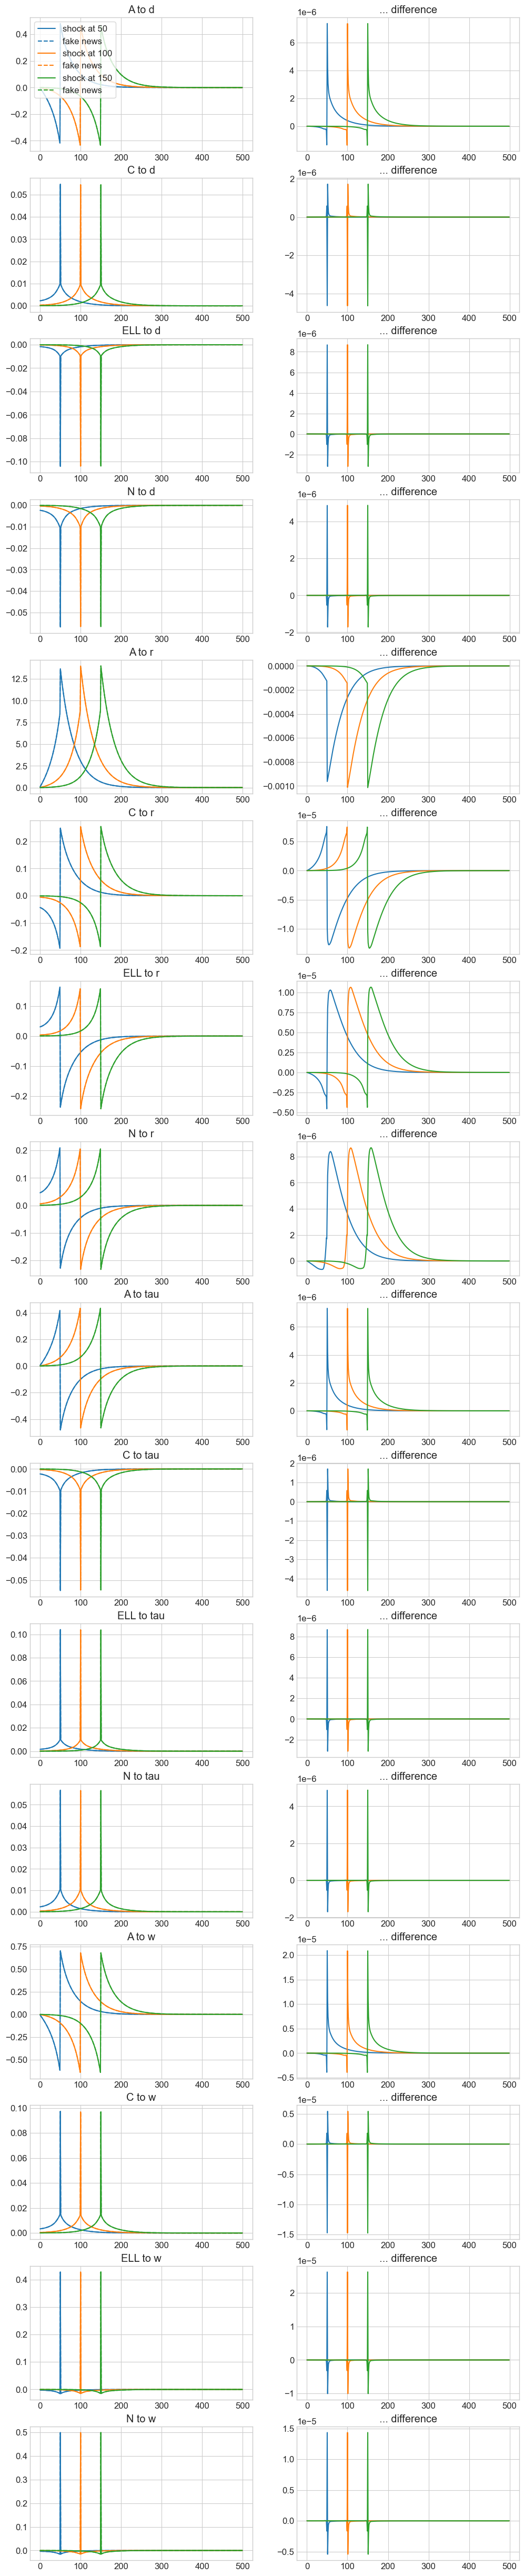

In [17]:
model.test_jacs(s_list=[50,100,150])

# Step 3a: Find non-linear transition path

## Find transition path

In [18]:
par.jump_istar = -0.10/4
model.find_transition_path(do_print=True)

finding the transition path:
 it =   0 -> max. abs. error = 1.41e-01
   0.00e+00 in NKPC_res
   1.41e-01 in clearing_A
   2.71e-02 in clearing_N
 it =   1 -> max. abs. error = 1.30e-02
   9.43e-05 in NKPC_res
   1.30e-02 in clearing_A
   4.82e-04 in clearing_N
 it =   2 -> max. abs. error = 7.51e-04
   4.45e-05 in NKPC_res
   6.26e-04 in clearing_A
   7.51e-04 in clearing_N
 it =   3 -> max. abs. error = 9.63e-05
   3.17e-06 in NKPC_res
   9.63e-05 in clearing_A
   6.67e-05 in clearing_N
 it =   4 -> max. abs. error = 5.38e-06
   6.19e-07 in NKPC_res
   5.38e-06 in clearing_A
   3.77e-06 in clearing_N
 it =   5 -> max. abs. error = 1.35e-06
   2.82e-08 in NKPC_res
   1.35e-06 in clearing_A
   4.50e-07 in clearing_N
 it =   6 -> max. abs. error = 9.48e-08
   2.96e-09 in NKPC_res
   9.48e-08 in clearing_A
   2.73e-08 in clearing_N
 it =   7 -> max. abs. error = 1.68e-08
   2.39e-10 in NKPC_res
   1.68e-08 in clearing_A
   3.54e-09 in clearing_N
 it =   8 -> max. abs. error = 1.43e-09
   

## Plot transitions

### shocks ###


c:\users\gmf123\dropbox\repositories\gemodeltools\GEModelTools\figures.py:109: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(np.arange(T_max),100*(pathvalue[:T_max]/ssvalue-1),label=label)


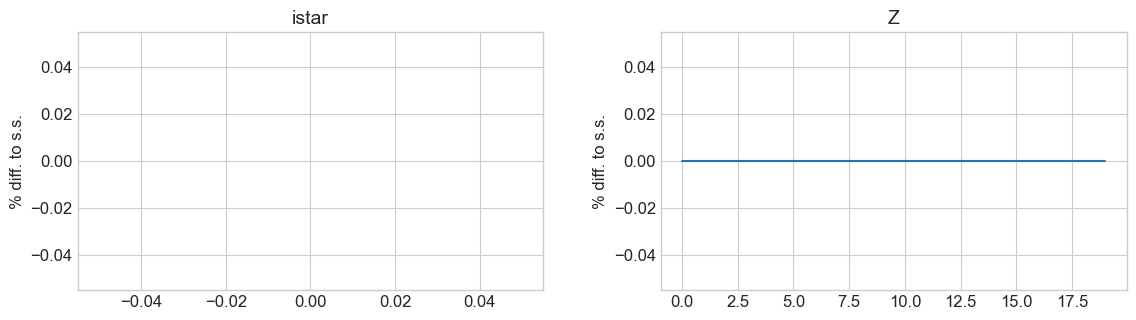


### varnames ###


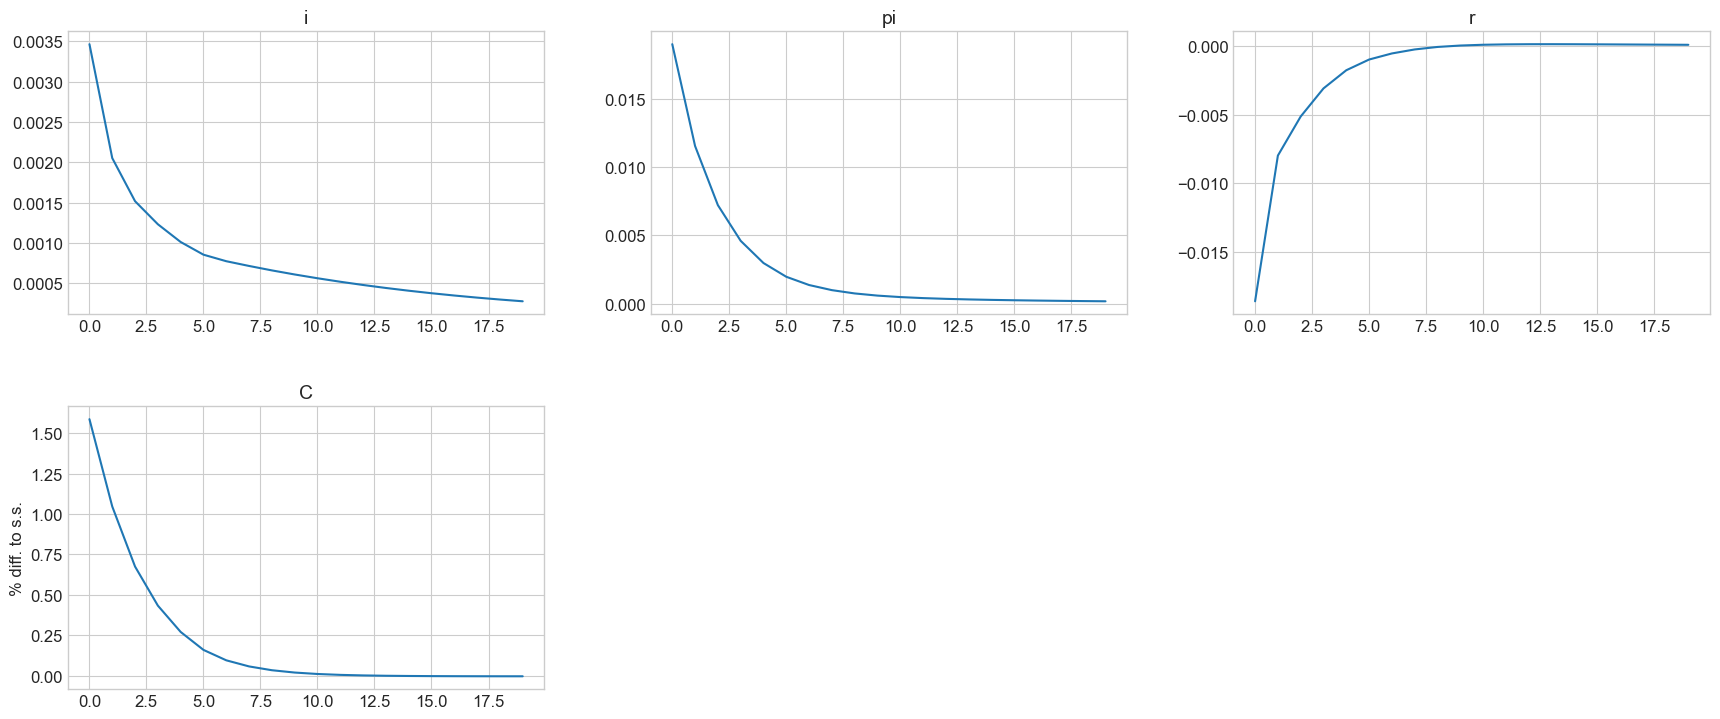


### tagets ###


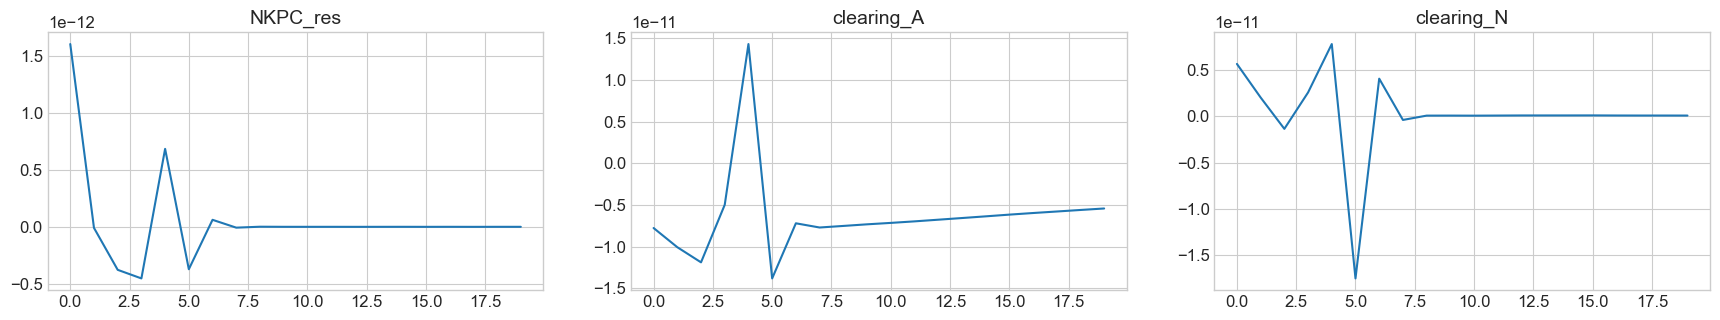

In [19]:
paths = ['i','pi','r','C']
lvl_value = ['i','pi','r']
model.show_IRFs(paths,lvl_value=lvl_value,T_max=20,ncols=3)

# Step 3b: Find linearized IRFs

In [20]:
model.find_IRFs(do_print=True)

linear transition path found in 0.1 secs [finding solution matrix: 0.1 secs]


### shocks ###


c:\users\gmf123\dropbox\repositories\gemodeltools\GEModelTools\figures.py:109: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(np.arange(T_max),100*(pathvalue[:T_max]/ssvalue-1),label=label)
c:\users\gmf123\dropbox\repositories\gemodeltools\GEModelTools\figures.py:111: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(np.arange(T_max),100*(IRFvalue[:T_max]/ssvalue-1),ls='--',label='linear')


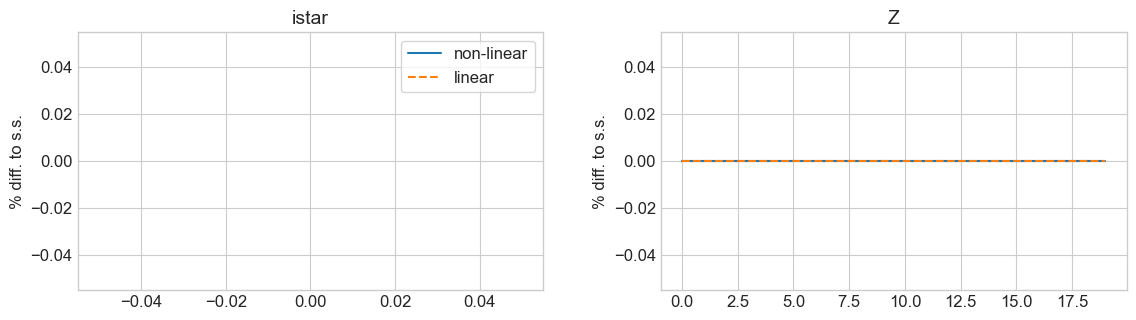


### varnames ###


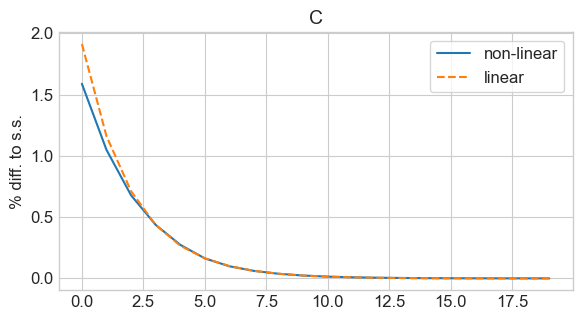


### tagets ###


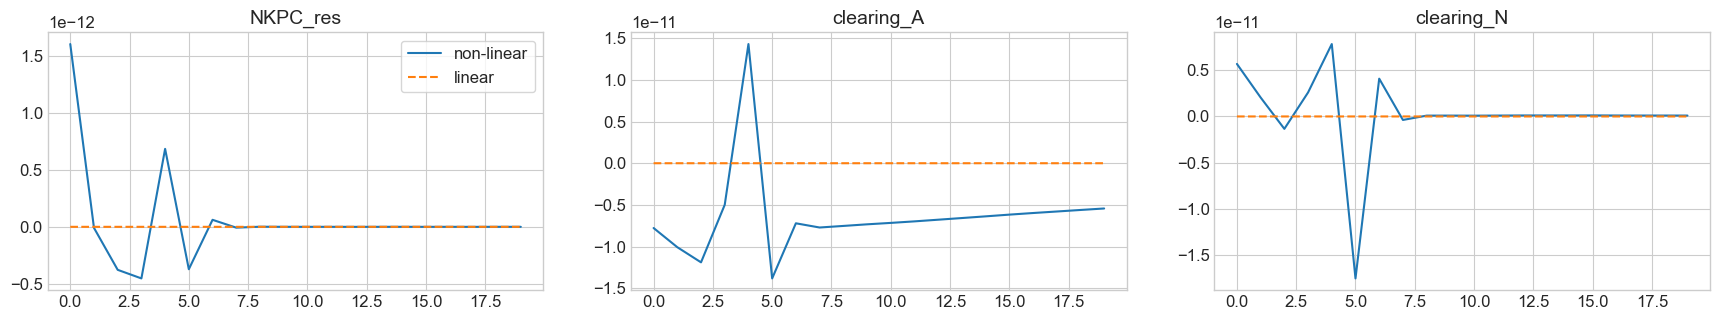

In [21]:
paths = ['C']
model.show_IRFs(paths,T_max=20,ncols=3,do_linear=True)

# Step 4. Simulation

In [22]:
np.random.seed(1917)
model.simulate(do_print=True)

simulation prepared in 9.4 secs [solution matrix: 0.1 secs, households: 9.2 secs]
aggregates simulated in 0.8 secs
household policies simulated in 8.1 secs
distribution simulated in 0.2 secs
aggregates calculated from distribution in 0.0 secs


In [23]:
def model_sim():
    
    fig = plt.figure(figsize=(12,8),dpi=100)

    ax = fig.add_subplot(2,2,1)
    ax.set_title('i')
    ax.plot(ss.i+sim.di,ls='--')
    ax.axhline(ss.i,color='black',zorder=0)

    ax = fig.add_subplot(2,2,2)
    ax.set_title('pi')
    ax.plot(ss.pi+sim.dpi,ls='--',)
    ax.axhline(ss.pi,color='black',zorder=0)
    
    ax = fig.add_subplot(2,2,3)
    ax.set_title('r')
    ax.plot(ss.r+sim.dr,ls='--',)
    ax.axhline(ss.r,color='black',zorder=0)
    
    ax = fig.add_subplot(2,2,4)
    ax.set_title('C')
    ax.plot(ss.C+sim.dC,ls='--',)
    ax.axhline(ss.C,color='black',zorder=0)
    

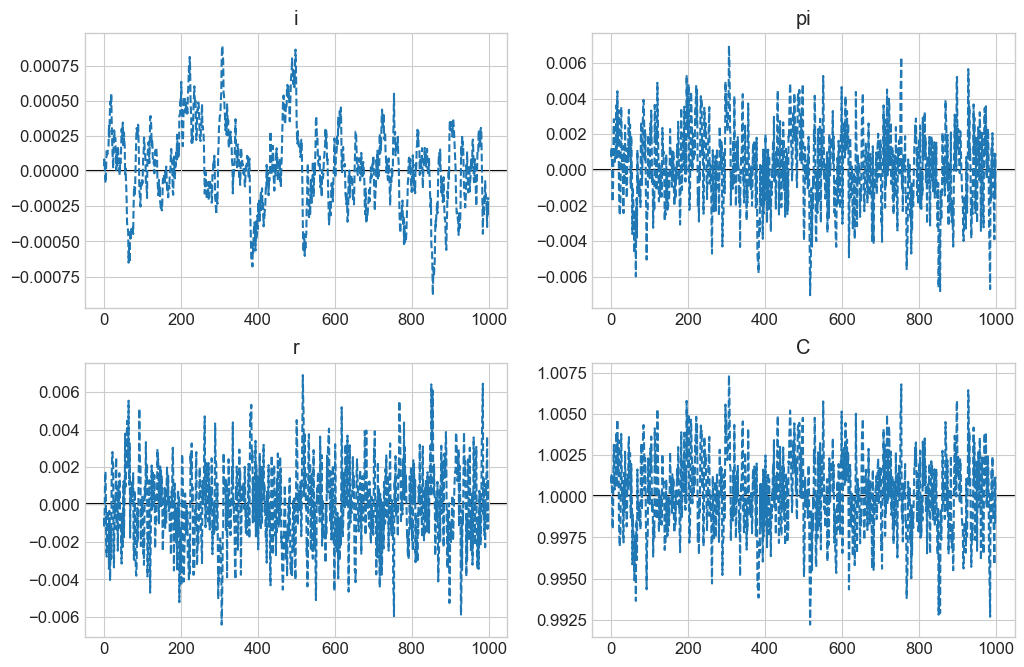

In [24]:
model_sim()